# Sentiment Analysis with Yelp Reviews

This dataset comes from the Yelp Dataset Challenge for NLP and sentiment analysis. I chose to create a classifier trained using the ACL IMDB movie review dataset for it's high quality, large amount of training examples and it's similar to what a user may write for a Yelp review. 

Training data: Large Movie Review Dataset http://ai.stanford.edu/~amaas/data/sentiment/

In [1]:
import pandas as pd
import numpy as np
import mglearn
import json
from collections import Counter
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV
from spacy.en import STOP_WORDS
import matplotlib.pyplot as plt

%matplotlib inline

/Users/brandon/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/brandon/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Training a Classifier using the Large Movie Review Data

For now I'll use a logistic regression model since the performance seems good enough based on the grid search results. If we are looking for better performance it might be good to test other classfiers.

In [2]:
# Training data loading
reviews_train = load_files('~/data/aclImdb/train/')
text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files('~/data/aclImdb/test/')
text_test, y_test = reviews_test.data, reviews_test.target

# Clean some of the HTML 
text_train = [doc.replace(b'<br />', b" ") for doc in text_train]
text_test = [doc.replace(b'<br />', b" ") for doc in text_test]

# Bag of words would use the countvectorizer method
# vect = CountVectorizer().fit(text_train)
# X_train = vect.transform(text_train)

# Sample of training 
# model = LogisticRegression()
# model.fit(X_train, y_train)

# Tf-idf and grid search for runing the logistic regression model
pipeline = make_pipeline(TfidfVectorizer(min_df=5, norm=None), LogisticRegression())
parameters = {'logisticregression__C': [.001, .01, .1, 1, 10]}  # grid search

grid = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
grid.fit(text_train, y_train)

print('Top CV score: %s' % grid.best_score_)

Top CV score: 0.89392


### Yelp Dataset

Our goal here is to leverage the model trained from movie reviews to identify the sentiment of the Yelp reviews. The data provided by Yelp has these 9 features: business_id, cool, date, funny, review_id, stars, text and useful. We will assign the text reviews from the text feature.

After identifying the predicted sentiment labels I spot-checked a few examples and they were correctly labeled. Since the Yelp dataset doesn't contain labels we can't verify precisely how well the model classified the reviews. After looking over the results it's interesting to see the positive reviews outweigh the negative from the sample. I wasn't expecting this as users are usually more driven to spend the time to write reviews if they experienced issues rather than had great experiences. I feel that sentiment analysis can have a great affect on quantifying data like user reviews. It has a lot of potential to better understand customers, businesses and products as well as influence other systems with the information it finds.

In [3]:
# Parsing the json file provided by Yelp
# Thank you - https://github.com/karenxiao/pandas-express
l = []
with open('../data/yelp-dataset/review.json', 'r') as f:
    for line in f:
        l.append(json.loads(line.rstrip()))
        
yelp_df = pd.DataFrame.from_dict(l)
reviews = yelp_df['text']
print(yelp_df.head(5))

              business_id  cool        date  funny               review_id  \
0  uYHaNptLzDLoV_JZ_MuzUA     0  2016-07-12      0  VfBHSwC5Vz_pbFluy07i9Q   
1  uYHaNptLzDLoV_JZ_MuzUA     0  2016-10-02      0  3zRpneRKDsOPq92tq7ybAA   
2  uYHaNptLzDLoV_JZ_MuzUA     0  2015-09-17      0  ne5WhI1jUFOcRn-b-gAzHA   
3  uYHaNptLzDLoV_JZ_MuzUA     0  2016-08-21      0  llmdwOgDReucVoWEry61Lw   
4  uYHaNptLzDLoV_JZ_MuzUA     0  2013-11-20      0  DuffS87NaSMDmIfluvT83g   

   stars                                               text  useful  \
0      5  My girlfriend and I stayed here for 3 nights a...       0   
1      3  If you need an inexpensive place to stay for a...       0   
2      3  Mittlerweile gibt es in Edinburgh zwei Ableger...       0   
3      4  Location is everything and this hotel has it! ...       0   
4      5  gute lage im stadtzentrum. shoppingmeile und s...       0   

                  user_id  
0  cjpdDjZyprfyDG3RlkVG3w  
1  bjTcT8Ty4cJZhEOEo01FGA  
2  AXgRULmWcME7J6Ix3

### Predictions

#### Comparing Samples

To spotcheck how well the model did we can read a couple of passages where the we have a sample from positive and negative reviews. The first is a good example of a postive review. The review contains strong words that might indicate a positive passage like "loved", "amazing", "incredible" and "excellent". There was a few negative sections within the review but this should be positive after reading. The second passage is an example of a negative review. This contains potentially indicating words like "no", "attitude", "awful".

In [4]:
collection = [reviews[0], reviews[1]]
p = grid.predict(collection)

for d, pred in zip(collection, p):
    print('%r \n>>> %s' % (d, pred))
    print()

'My girlfriend and I stayed here for 3 nights and loved it. The location of this hotel and very decent price makes this an amazing deal. When you walk out the front door Scott Monument and Princes street are right in front of you, Edinburgh Castle and the Royal Mile is a 2 minute walk via a close right around the corner, and there are so many hidden gems nearby including Calton Hill and the newly opened Arches that made this location incredible.\n\nThe hotel itself was also very nice with a reasonably priced bar, very considerate staff, and small but comfortable rooms with excellent bathrooms and showers. Only two minor complaints are no telephones in room for room service (not a huge deal for us) and no AC in the room, but they have huge windows which can be fully opened. The staff were incredible though, letting us borrow umbrellas for the rain, giving us maps and directions, and also when we had lost our only UK adapter for charging our phones gave us a very fancy one for free.\n\nI

#### Word Frequencies

Another method that could shed additional insight could be word frequencies from common words found in sentiment analysis lexicons. Unfortunitely when I was spot-checking some samples, most were moderately short texts that didn't have many overlapping words aside from common stop words. 

In [10]:
test = [w for w in reviews[1].split() if w not in STOP_WORDS]
feature_names = np.array(top_vectorizer.get_feature_names())
print(Counter(test).most_common(10))

print()
for word in reviews[0].split():
    if word in feature_names[sorted_by_tfidf[-20:]]:
        print(word)
        
print('----')
for word in reviews[0].split():
    if word in feature_names[sorted_by_tfidf[:20]]:
        print(word)

[('If', 2), ('place', 2), ('stay', 2), ("you're", 2), ('right', 2), ('No', 2), ('room', 2), ('It', 2), ('need', 1), ('inexpensive', 1)]

would
recommend
----


### Exploring the model

We can use tfidf scaling to help find words that distinguish the sentiment. Some of the negative words were "worst", "waste", "awful" and "bad"; while some of the positive words were "great", "excellent", "perfect" and "best".

Lowest tfidf features: ['briers' 'lanchester' 'redgrave' 'blore' 'svenson' 'inarritu' 'lamour'
 'sweetin' 'sweid' 'swinton']
Highest tfidf features: ['tint' 'would' 'ribs' 'recommend' 'go' 'waited' 'yum' 'gas' 'salty' 'ozzy']


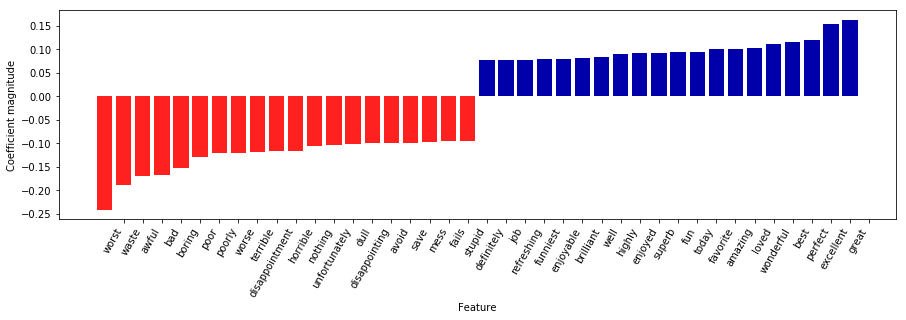

In [7]:
top_vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']

# yelp data
x_train = top_vectorizer.transform(yelp_df['text'])
# max value for each feature
max_v = x_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_v.argsort()

feature_names = np.array(top_vectorizer.get_feature_names())

print('Lowest tfidf features: %s' % feature_names[sorted_by_tfidf[:10]])
print('Highest tfidf features: %s' % feature_names[sorted_by_tfidf[-10:]])

# Visualization using the mglearn package
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps['logisticregression'].coef_,
                                    feature_names, n_top_features=20)

In [8]:
# Predict sentiment for all yelp reviews, add sentiment feature
yelp_df['sentiment'] = grid.predict(yelp_df['text'])

1 = POSITIVE
0 = NEGATIVE


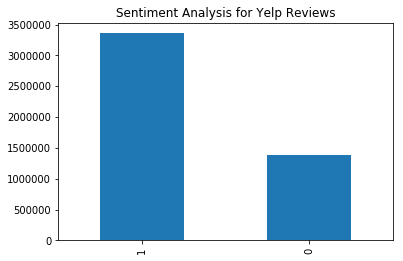

In [9]:
# Plot distribution of predicted review sentiment
yelp_df['sentiment'].value_counts().plot(kind='bar', 
                                         title='Sentiment Analysis for Yelp Reviews')

print('1 = POSITIVE\n0 = NEGATIVE')

### Resources

http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

Intro to Machine Learning with Python

https://github.com/karenxiao/pandas-express
    
https://www.yelp.com/dataset/

